In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd

# Cargar los tres datasets
df_pca = pd.read_csv("movies_pca_features.csv")
df_umap = pd.read_csv("movies_umap.csv")
df_combined = pd.read_parquet("movies_combined_features.parquet")

# Mostrar info general
print("\nPCA Features")
print(df_pca.shape)
print(df_pca.head(3))

print("\nUMAP Features")
print(df_umap.shape)
print(df_umap.head(3))

print("\nCombined Features (Parquet)")
print(df_combined.shape)
print(df_combined.head(3))

# Ver columnas que comparten
common_cols = set(df_pca.columns).intersection(df_umap.columns)
print("\nColumnas comunes entre PCA y UMAP:", common_cols)

common_with_combined = set(df_combined.columns).intersection(df_pca.columns)
print("Columnas comunes entre Combined y PCA:", common_with_combined)


--- PCA Features ---
(5831, 90)
      PCA_1      PCA_2     PCA_3     PCA_4     PCA_5     PCA_6     PCA_7  \
0  5.506134  -9.820137 -6.922371 -3.651695  0.763472 -2.586869 -1.122717   
1 -9.269553 -15.366420  6.126430  7.487738  1.485180 -0.131593 -0.577547   
2  6.158485  -8.471273  4.386673  2.442752 -0.455687  0.283006  0.503773   

      PCA_8     PCA_9    PCA_10  ...    PCA_81    PCA_82    PCA_83    PCA_84  \
0  2.270080  1.137109  0.065042  ...  0.529140 -0.675860  0.652585 -0.422969   
1 -0.539436 -0.319263  1.266533  ...  0.155312 -0.116008 -0.660685 -0.109825   
2  0.642149  0.097381 -2.145893  ... -1.072545 -0.392253 -0.021449 -0.842772   

     PCA_85    PCA_86    PCA_87    PCA_88    PCA_89    PCA_90  
0 -0.324499 -0.402530 -0.209635 -0.553781  0.117893  0.121579  
1 -0.175769  0.038308 -0.188315  0.265364 -0.599632 -0.168388  
2  0.863911  0.104372  0.352982  0.723910  0.466636  0.185919  

[3 rows x 90 columns]

--- UMAP Features ---
(5831, 50)
      UMAP_1    UMAP_2    UM

In [ ]:
import os
import pandas as pd

print("¿Existe el archivo?", os.path.exists("movies_combined_features.parquet"))

try:
    df_combined = pd.read_parquet("movies_combined_features.parquet")
    print("\nArchivo encontrado y cargado correctamente:")
    print(df_combined.shape)
    print(df_combined.columns[:15])  
    print(df_combined.head(3))
except Exception as e:
    print("\nError al leer el archivo:", e)

¿Existe el archivo? True

Archivo encontrado y cargado correctamente:
(5831, 3)
Index(['movieId', 'title', 'features'], dtype='object')
  movieId                 title  \
0     619             Ed (1996)   
1   33826    Saint Ralph (2004)   
2  140289  Men & Chicken (2015)   

                                            features  
0  [0.19058356, 0.0979772, 0.076737955, 0.2980004...  
1  [0.7005998, 0.025042623, 0.017594602, 0.319023...  
2  [0.5831317, 0.35357442, 0.23846312, 0.5706941,...  


In [13]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [ ]:
def load_data(file_path):
    df = pd.read_csv(file_path)

    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

    feature_cols = [col for col in numeric_cols if not col.lower() in ['id', 'index', 'movieid', 'movie_id']]
    
    print(f"Dataset cargado: {df.shape}")
    print(f"Número de características: {len(feature_cols)}")
    print(f"Primeras columnas de características: {feature_cols[:5]}")
    
    return df, feature_cols

print("CARGANDO DATOS")

CARGANDO DATOS


In [15]:
df_pca, features_pca = load_data('movies_pca_features.csv')
df_umap, features_umap = load_data('movies_umap.csv')

Dataset cargado: (5831, 90)
Número de características: 90
Primeras columnas de características: ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4', 'PCA_5']
Dataset cargado: (5831, 50)
Número de características: 50
Primeras columnas de características: ['UMAP_1', 'UMAP_2', 'UMAP_3', 'UMAP_4', 'UMAP_5']


In [ ]:
def kmeans_from_scratch(X, k=5, max_iters=100, random_state=42):

    np.random.seed(random_state)
    
    n_samples, n_features = X.shape
    
    centroids = initialize_centroids_plus_plus(X, k)
    

    labels = np.zeros(n_samples)
    
    for iteration in range(max_iters):
        old_centroids = centroids.copy()
        
        distances = np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2))
        labels = np.argmin(distances, axis=0)
        
        for i in range(k):
            if np.sum(labels == i) > 0:
                centroids[i] = X[labels == i].mean(axis=0)
        
        if np.allclose(old_centroids, centroids):
            break
    
    inertia = 0
    for i in range(k):
        cluster_points = X[labels == i]
        inertia += np.sum((cluster_points - centroids[i])**2)
    
    return centroids, labels, iteration + 1, inertia


def initialize_centroids_plus_plus(X, k):
    n_samples = X.shape[0]
    centroids = []

    centroids.append(X[np.random.randint(n_samples)])

    for _ in range(k - 1):
        distances = np.array([min([np.inner(c-x, c-x) for c in centroids]) for x in X])
        probs = distances / distances.sum()
        cumulative_probs = probs.cumsum()
        r = np.random.rand()
        
        for j, p in enumerate(cumulative_probs):
            if r < p:
                centroids.append(X[j])
                break
    
    return np.array(centroids)

In [ ]:
def elbow_method(X, max_k=15, method='sklearn'):
    inertias = []
    silhouette_scores = []
    k_range = range(2, max_k + 1)
    
    print(f"\nCalculando métricas para k=2 hasta k={max_k}...")
    
    for k in k_range:
        if method == 'sklearn':
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            labels = kmeans.fit_predict(X)
            inertia = kmeans.inertia_
        else:
            _, labels, _, inertia = kmeans_from_scratch(X, k=k)
        
        inertias.append(inertia)

        if len(X) < 10000:
            silhouette_avg = silhouette_score(X, labels)
            silhouette_scores.append(silhouette_avg)
        
        if k % 3 == 0:
            print(f"k={k}: Inercia={inertia:.2f}", end="")
            if len(X) < 10000:
                print(f", Silhouette={silhouette_scores[-1]:.3f}")
            else:
                print()
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
    axes[0].set_xlabel('Número de Clusters (k)', fontsize=12)
    axes[0].set_ylabel('Inercia (WCSS)', fontsize=12)
    axes[0].set_title('Método del Codo', fontsize=14, fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    
    # Gráfico de Silhouette Score
    if len(X) < 10000:
        axes[1].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
        axes[1].set_xlabel('Número de Clusters (k)', fontsize=12)
        axes[1].set_ylabel('Silhouette Score', fontsize=12)
        axes[1].set_title('Método Silhouette', fontsize=14, fontweight='bold')
        axes[1].grid(True, alpha=0.3)

        best_k = k_range[np.argmax(silhouette_scores)]
        axes[1].axvline(x=best_k, color='g', linestyle='--', 
                       label=f'Mejor k={best_k}')
        axes[1].legend()
    else:
        axes[1].text(0.5, 0.5, 'Dataset muy grande\nSilhouette no calculado', 
                    ha='center', va='center', fontsize=14)
        axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return inertias, silhouette_scores if len(X) < 10000 else None


In [ ]:

def evaluate_clustering(X, labels, k):

    print(f"\n{'='*60}")
    print(f"EVALUACIÓN DEL CLUSTERING (k={k})")
    print(f"{'='*60}")
    
    if len(X) < 10000:
        silhouette = silhouette_score(X, labels)
        print(f"Silhouette Score: {silhouette:.4f}")
        print(f"  → Rango: [-1, 1], mejor cuando cercano a 1")
    else:
        print("Silhouette Score: (omitido por tamaño del dataset)")
    
    db_index = davies_bouldin_score(X, labels)
    print(f"Davies-Bouldin Index: {db_index:.4f}")
    print(f"  → Mejor cuando es más bajo (clusters compactos y separados)")
    
    ch_score = calinski_harabasz_score(X, labels)
    print(f"Calinski-Harabasz Score: {ch_score:.4f}")
    print(f"  → Mejor cuando es más alto (clusters densos y bien separados)")
    
    print(f"\nDistribución de películas por cluster:")
    unique, counts = np.unique(labels, return_counts=True)
    for cluster_id, count in zip(unique, counts):
        percentage = (count / len(labels)) * 100
        print(f"  Cluster {cluster_id}: {count} películas ({percentage:.1f}%)")
    
    return {
        'silhouette': silhouette if len(X) < 10000 else None,
        'davies_bouldin': db_index,
        'calinski_harabasz': ch_score
    }

In [ ]:
def visualize_clusters_2d(X, labels, centroids=None, title="Clustering Results"):
    plt.figure(figsize=(12, 8))
    
    X_2d = X[:, :2] if X.shape[1] >= 2 else X

    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, 
                         cmap='viridis', alpha=0.6, s=50)
    

    if centroids is not None:
        centroids_2d = centroids[:, :2] if centroids.shape[1] >= 2 else centroids
        plt.scatter(centroids_2d[:, 0], centroids_2d[:, 1], 
                   c='red', marker='X', s=200, 
                   edgecolors='black', linewidths=2,
                   label='Centroides')
    
    plt.colorbar(scatter, label='Cluster ID')
    plt.xlabel('Componente 1', fontsize=12)
    plt.ylabel('Componente 2', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    if centroids is not None:
        plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
def run_kmeans_analysis(df, feature_cols, dataset_name, optimal_k=None):
    print(f"ANÁLISIS K-MEANS: {dataset_name}")
    

    X = df[feature_cols].values
    

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    print(f"\nDatos preparados: {X_scaled.shape}")
    

    if optimal_k is None:
        print("\nEncontrar K óptimo")
        inertias, silhouettes = elbow_method(X_scaled, max_k=15)
        

        if silhouettes is not None:
            optimal_k = np.argmax(silhouettes) + 2
            print(f"\nK sugerido por Silhouette: {optimal_k}")
        else:
            optimal_k = 5 
            print(f"\nUsando k={optimal_k} por defecto")
    

    print(f"\n Aplicar K-means con k={optimal_k}")
    

    print("\nK-means desde cero:")
    centroids_scratch, labels_scratch, iters, inertia = kmeans_from_scratch(
        X_scaled, k=optimal_k
    )
    print(f"Convergió en {iters} iteraciones")
    print(f"Inercia final: {inertia:.2f}")
    

    print("\nK-means de scikit-learn:")
    kmeans_sklearn = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    labels_sklearn = kmeans_sklearn.fit_predict(X_scaled)
    print(f"Inercia: {kmeans_sklearn.inertia_:.2f}")
    
    #Evaluar clustering
    print("\n Evaluación")
    metrics = evaluate_clustering(X_scaled, labels_sklearn, optimal_k)
    

    print("\nVisualización")
    visualize_clusters_2d(X_scaled, labels_sklearn, kmeans_sklearn.cluster_centers_,
                         f"K-means Clustering - {dataset_name} (k={optimal_k})")
    

    df_result = df.copy()
    df_result['cluster'] = labels_sklearn
    output_file = f"{dataset_name.lower().replace(' ', '_')}_clustered.csv"
    df_result.to_csv(output_file, index=False)
    print(f"\nResultados guardados en: {output_file}")
    
    return {
        'labels': labels_sklearn,
        'centroids': kmeans_sklearn.cluster_centers_,
        'metrics': metrics,
        'k': optimal_k
    }


############################################################
ANÁLISIS K-MEANS: PCA Features
############################################################

Datos preparados: (5831, 90)

Encontrar K óptimo

Calculando métricas para k=2 hasta k=15...
k=3: Inercia=515214.04, Silhouette=0.025
k=6: Inercia=503996.57, Silhouette=-0.046
k=9: Inercia=493345.11, Silhouette=-0.058
k=12: Inercia=483632.82, Silhouette=-0.054
k=15: Inercia=474213.48, Silhouette=-0.061


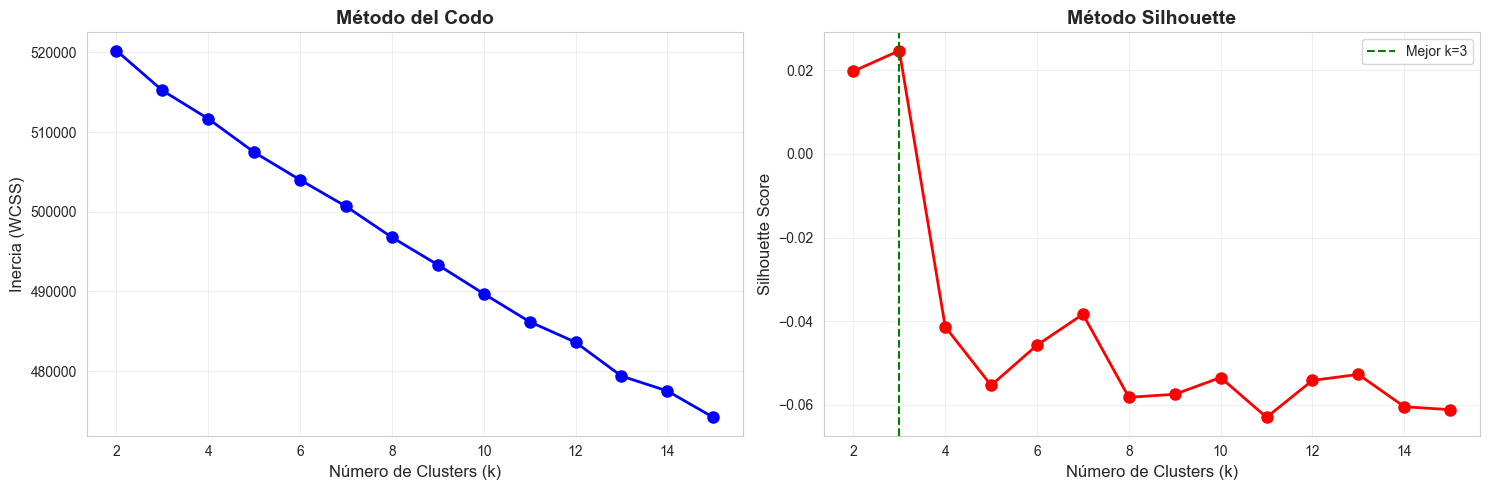


K sugerido por Silhouette: 3

 Aplicar K-means con k=3

K-means desde cero:
Convergió en 85 iteraciones
Inercia final: 515963.59

K-means de scikit-learn:
Inercia: 515214.04

 Evaluación

EVALUACIÓN DEL CLUSTERING (k=3)
Silhouette Score: 0.0247
  → Rango: [-1, 1], mejor cuando cercano a 1
Davies-Bouldin Index: 6.0533
  → Mejor cuando es más bajo (clusters compactos y separados)
Calinski-Harabasz Score: 54.1607
  → Mejor cuando es más alto (clusters densos y bien separados)

Distribución de películas por cluster:
  Cluster 0: 379 películas (6.5%)
  Cluster 1: 908 películas (15.6%)
  Cluster 2: 4544 películas (77.9%)

Visualización


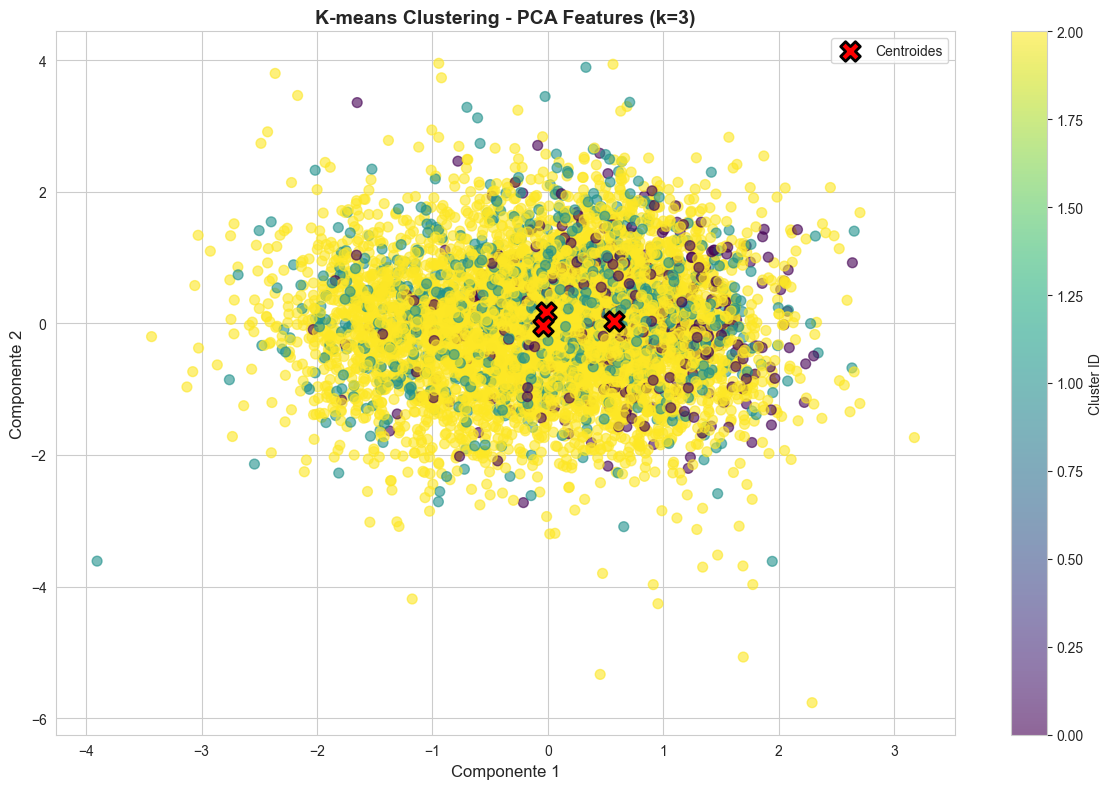


Resultados guardados en: pca_features_clustered.csv

############################################################
ANÁLISIS K-MEANS: UMAP Features
############################################################

Datos preparados: (5831, 50)

Encontrar K óptimo

Calculando métricas para k=2 hasta k=15...
k=3: Inercia=137049.89, Silhouette=0.338
k=6: Inercia=87712.05, Silhouette=0.301
k=9: Inercia=67823.32, Silhouette=0.279
k=12: Inercia=56606.87, Silhouette=0.252
k=15: Inercia=48299.12, Silhouette=0.262


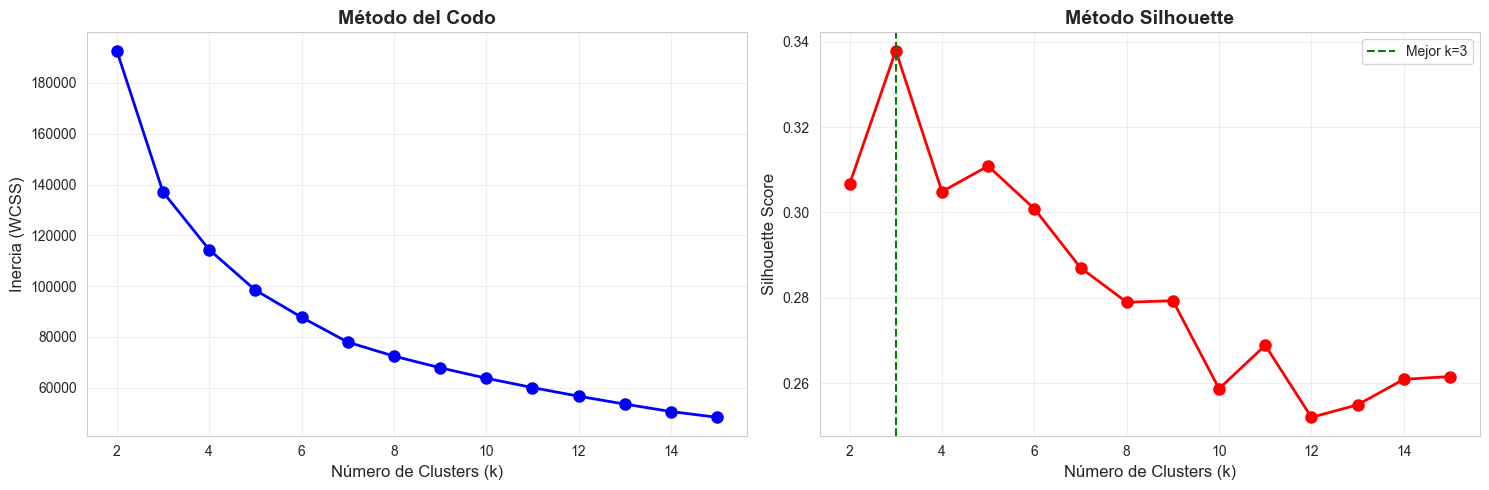


K sugerido por Silhouette: 3

 Aplicar K-means con k=3

K-means desde cero:
Convergió en 11 iteraciones
Inercia final: 137049.86

K-means de scikit-learn:
Inercia: 137049.89

 Evaluación

EVALUACIÓN DEL CLUSTERING (k=3)
Silhouette Score: 0.3379
  → Rango: [-1, 1], mejor cuando cercano a 1
Davies-Bouldin Index: 1.0565
  → Mejor cuando es más bajo (clusters compactos y separados)
Calinski-Harabasz Score: 3285.0335
  → Mejor cuando es más alto (clusters densos y bien separados)

Distribución de películas por cluster:
  Cluster 0: 1290 películas (22.1%)
  Cluster 1: 2525 películas (43.3%)
  Cluster 2: 2016 películas (34.6%)

Visualización


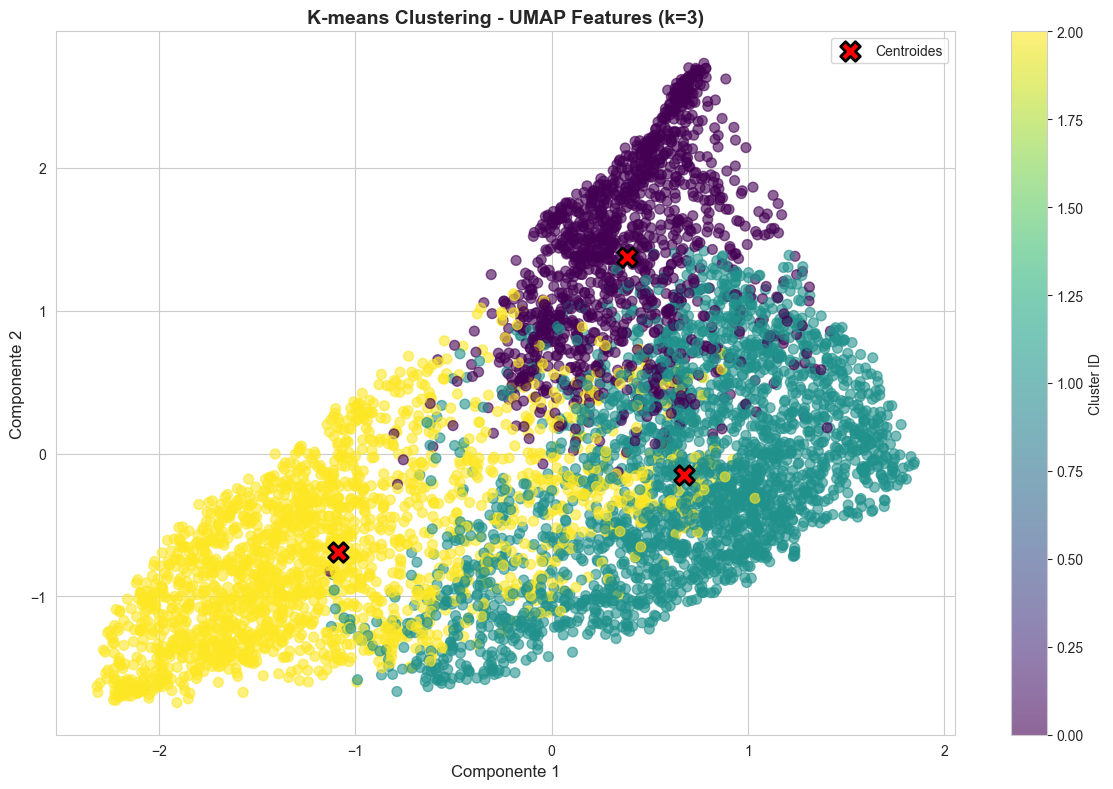


Resultados guardados en: umap_features_clustered.csv


In [ ]:

results_pca = run_kmeans_analysis(df_pca, features_pca, "PCA Features")

results_umap = run_kmeans_analysis(df_umap, features_umap, "UMAP Features")

In [ ]:
print("COMPARACIÓN FINAL: PCA vs UMAP")

comparison_df = pd.DataFrame({
    'Método': ['PCA', 'UMAP'],
    'K óptimo': [results_pca['k'], results_umap['k']],
    'Davies-Bouldin': [
        results_pca['metrics']['davies_bouldin'],
        results_umap['metrics']['davies_bouldin']
    ],
    'Calinski-Harabasz': [
        results_pca['metrics']['calinski_harabasz'],
        results_umap['metrics']['calinski_harabasz']
    ]
})

print(comparison_df.to_string(index=False))
print("\nMejor método: ", end="")
if results_pca['metrics']['davies_bouldin'] < results_umap['metrics']['davies_bouldin']:
    print("PCA (menor Davies-Bouldin Index)")
else:
    print("UMAP (menor Davies-Bouldin Index)")


################################################################################
COMPARACIÓN FINAL: PCA vs UMAP
################################################################################
Método  K óptimo  Davies-Bouldin  Calinski-Harabasz
   PCA         3        6.053270          54.160703
  UMAP         3        1.056529        3285.033481

Mejor método: UMAP (menor Davies-Bouldin Index)
